# 18460 Project

In [1]:
%load_ext autoreload
%autoreload 2

from tasks import *
import numpy as np
from server import Server

First, we initialize the task for a given configuration

In [2]:
#task = lrt.LinearRegressionTask(lrt.solo_config) # Linear regression
#task = ct.CircleTask(ct.solo_config) # Circle
task = lgrt.LogisticRegressionTask() # Logistic regression with mushrooms

Intializing task LogisticRegressionTask with config Config(clients=4, number=200, lr=0.001)


Seeing the data

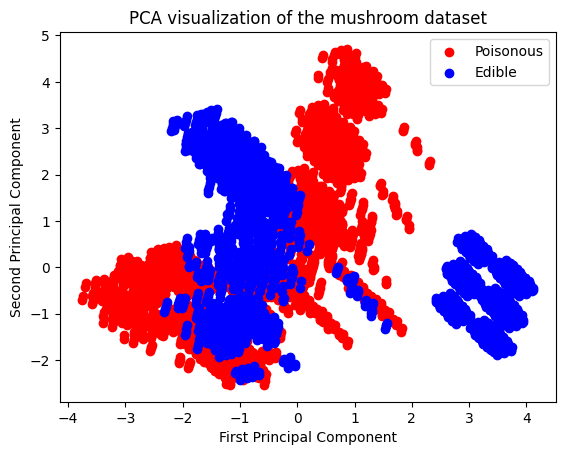

In [3]:
task.visualize()

Then, we define our optimization problem

In [14]:
problem = task.get_problem()
partitions = task.get_partitions()

Solve iteratively using federated learning

In [15]:
# Create server and initialize clients, before iteratively updating the consensus variables
server = Server(problem)
server.connect_clients(partitions) # add parameters and communicate datasets

k = 0
last_cost = float('infinity')
while k < problem.max_iter and server.delta > problem.tol:
    consensus = server.consensus.flatten()
    
    current_cost = problem.loss(consensus, task.dataset, problem.hyper_parameters)
    
    if k % 500 == 0:
        print(f'''
        Iteration {k}: {consensus}
        Cost: {current_cost}

        ''')
    
    # perform new iteration
    server.run_iteration(k+1)
    
    if np.linalg.norm(current_cost - last_cost) < problem.ctol:
        print(f"Condition reached: change in cost is {np.linalg.norm(current_cost - last_cost)} "
              f"which is smaller than {problem.ctol}")
        last_cost = current_cost
        break
        
    last_cost = current_cost
    
    k = k + 1
    
solution = server.consensus.flatten()

if k >= problem.max_iter and server.delta > problem.tol:
    raise Exception("Did not converge")
    
if server.delta <= problem.tol:
    print(f"Condition reached: change in solution is {server.delta} "
          f"which is smaller than {problem.tol}")

print("")
print(f"Solution: {solution}")
print(f"Associated cost: {last_cost}")
print(f"Achieved in {k} iterations")


        Iteration 0: [-0.05524081  0.32173016 -0.16517719  0.78863018 -0.32988305 -0.72443755
 -0.79460502 -1.07536833 -1.39838798 -1.76723868 -0.40490582  1.1413736
  1.51897427  1.02011613 -1.21099483 -0.48179661  0.59420043  2.52207273
  0.4371625  -0.20793635 -0.15856284 -0.30005725  0.89668405]
        Cost: 21678.623547685205

        

        Iteration 500: [-0.0071781   0.29290487 -0.24192024  0.00476517 -0.23626069 -0.72375092
 -0.92263404 -0.0997084  -0.9569006  -1.32744611 -0.71081352  0.46235669
  0.86300722  0.38699025 -0.85752089 -0.48179661  0.76908328  2.20724999
  0.40691029 -0.39969425  0.0732711  -0.13191444  0.39503425]
        Cost: 11193.292459638502

        

        Iteration 1000: [-0.0287706   0.34317253 -0.21243148 -0.48566625 -0.18506091 -0.65808158
 -1.13102188  0.40925929 -0.69749418 -0.74540873 -0.8892113   0.11688769
  0.56918552  0.19894877 -0.69807566 -0.48179661  0.91831178  1.92191931
  0.72864621 -0.63363037  0.13538903 -0.00350958  0.30589847]
 


        Iteration 12000: [-0.09593353  0.64109589 -0.03874314 -0.8443039  -0.80904602 -1.27923665
 -2.147492    2.57469762 -0.40223279  0.31219116 -0.931981   -1.8521047
 -0.35175383 -0.31556636 -0.12246575 -0.48179661  3.33555908  0.49414113
  1.13826282 -0.3213138  -0.19673451  0.0277993  -0.0956835 ]
        Cost: 1450.2300100676653

        

        Iteration 12500: [-0.09299336  0.64021502 -0.03652045 -0.82753466 -0.83348354 -1.25984126
 -2.16569189  2.61888364 -0.40708133  0.33370903 -0.94048769 -1.90189862
 -0.36108507 -0.31502695 -0.12029571 -0.48179661  3.34533298  0.51528649
  1.15491386 -0.3450685  -0.21316981  0.03147168 -0.11127841]
        Cost: 1441.5574383275355

        

        Iteration 13000: [-0.09093537  0.64173689 -0.03566471 -0.81390292 -0.86260225 -1.24341007
 -2.18879167  2.66306499 -0.41207581  0.3655173  -0.94933978 -1.94562143
 -0.36661879 -0.31508378 -0.11849185 -0.48179661  3.35439094  0.53612329
  1.16855234 -0.37615887 -0.23322753  0.03903405 -0.1258

Exception: Did not converge

## Visualization of the solution

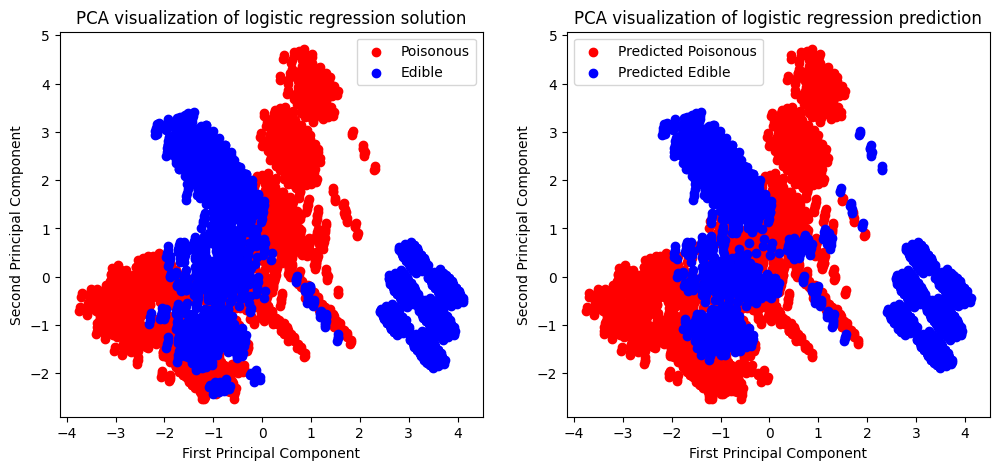

In [33]:
task.visualize_solution(solution)